In [1]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

%matplotlib inline

from sklearn.datasets import load_iris

In [2]:
class Input(object):
    def __init__(self,input_shape):
        self.input_shape = input_shape
        pass
    
    def forward(self,x):
        if x.shape != self.input_shape:
            raise Exception('Exception: x.shape != self.input_shape')
        return x
    
    def __rep__(self):
        return "{0}".format(self.__class__)
    
    def __str__(self):
        return "Input shape : {0}".format(self.input_shape)

In [3]:
class Dense(object):
    def __init__(self,inputs, units, activation, learning_rate=None):
        self.activation = activation
        self.inputs = inputs
        self.units = units
        
        self.weights = np.random.rand(inputs,units)
        
        if learning_rate is None:
            learning_rate = 0.5
        self.learning_rate = learning_rate
        pass
    
    def forward(self,x):
        self.activated = self.activation((np.dot(self.weights.T,x)))
        return self.activated
    
    def update(self,x):
        self.weights -= x*self.learning_rate
        pass
    
    def __rep__(self):
        return "{0}".format(self.__class__)
    
    def __str__(self):
        return "{0}".format(self.weights.shape)

In [4]:
class Model(object):
    def __init__(self, layers=[],placeholder=None):
        self.placeholder = placeholder
        self.layers = layers
        pass
    
    def add(self,layer=None):
        self.layers.append(layer)
        pass
    
    def fit(self,x,labels,epochs,loss, optimizer):
        history = []
        
        input_layer  = self.layers[0]
        hidden_layer = self.layers[1]
        output_layer = self.layers[2]
        
        for _ in tqdm(range(epochs)):
            cost = 0.0
            for i in range(len(x_train)):
                xx = np.array(x[i])
                yy = np.array(labels[i])
                
                # Forward propagation
                a0 = input_layer.forward(xx)
                a1 = hidden_layer.forward(a0)
                o  = output_layer.forward(a1)
                
                # Cost
                diff = (o-yy)
                cost += loss(diff)
                
                # Back propagation
                common = ((diff)*optimizer(o)).T
                w1 = np.dot(a1,common)
#                 print("{0}x{1} = {2}".format(a2.shape,common.shape,w2.shape))
            
                common = np.dot(common,output_layer.weights.T)*optimizer(a1.T)
                w0 = np.dot(a0,(common))
#                 print("{0}x{1} = {2}".format(a0.shape,common.shape,w0.shape))
                
                # Update weights
                output_layer.update(w1)
                hidden_layer.update(w0)
                
            history.append(cost/len(x_train))
            
        return history
    
    def predict(self,x):
        input_layer  = self.layers[0]
        hidden_layer = self.layers[1]
        output_layer = self.layers[2]
        
        a0 = input_layer.forward(x)
        a1 = hidden_layer.forward(a0)
        o  = output_layer.forward(a1)
        
        return o
    
    def __rep__(self):
        return "{0}".format(self.__class__)
    
    def __str__(self):
        return "Layers : {0}".format(self.layers)

In [5]:
# Activation function(s)
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    return z*(1.0-z)

def tanh(z):
    return np.tanh(z)

def tanh_prime(z):
    return 1.0 - z**2

def softmax(z):
    return np.exp(z)/np.sum(np.exp(z))

def relu(z):
    return np.max(0,z)

# Loss function(s)
def rmse(x):
    return np.sum(np.square(x)/2)

In [6]:
# Data preprocessing
iris = load_iris()

labels = ['setosa','versicolor','virginica']
categories = np.array([[1,0,0],[0,1,0],[0,0,1]])

x_train = np.array([m.reshape(4,1) for m in iris.data])
y_train = np.array([categories[m].reshape(3,1) for m in iris.target])

In [7]:
# Training data
# x_train = np.array([
#                     [[1],[0]],
#                     [[0],[0]],
#                     [[0],[1]],
#                     [[1],[1]],
#                     [[1],[0]],
#                     [[0],[0]],
#                     [[0],[1]],
#                     [[1],[1]]
#                    ])
# y_train = np.array([
#                     [[0]],
#                     [[0]],
#                     [[0]],
#                     [[1]],
#                     [[0]],
#                     [[0]],
#                     [[0]],
#                     [[1]]
#                     ])

# x_train = np.array([
#                     [[1],[0]],
#                     [[0],[0]],
#                     [[0],[1]],
#                     [[1],[1]],
#                     [[1],[0]],
#                     [[0],[0]],
#                     [[0],[1]],
#                     [[1],[1]]
#                    ])
# y_train = np.array([
#                     [[0],[1]],
#                     [[0],[0]],
#                     [[1],[0]],
#                     [[1],[1]],
#                     [[0],[1]],
#                     [[0],[0]],
#                     [[1],[0]],
#                     [[1],[1]]
#                     ])

In [13]:
model = Model(layers=[Input(input_shape=(4,1)),
                     Dense(inputs=4, units=9, activation=sigmoid),
                     Dense(inputs=9, units=3, activation=sigmoid)
                    ])

# model.add(Input(input_shape=(2,1)))
# model.add(Dense(inputs=2, units=3, activation=sigmoid))
# model.add(Dense(inputs=3, units=1, activation=sigmoid))

In [14]:
yy = model.fit(x=x_train, labels=y_train, epochs=500,loss=rmse, optimizer=sigmoid_prime)

100%|██████████| 500/500 [00:02<00:00, 228.88it/s]


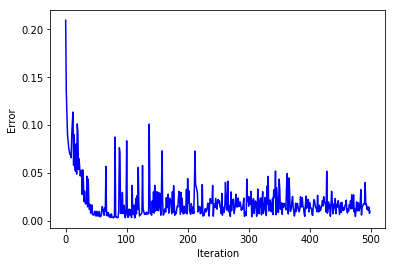

In [15]:
plt.figure()
plt.plot(yy,color = 'b')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.show()

In [16]:
pred = model.predict(np.array([[5.1],
        [3.5],
        [1.4],
        [0.2]]))
m = np.argmax(softmax(pred))
print(labels[np.argmax(pred)], pred[m])         # We are expecting setosa

setosa [0.99135874]


In [17]:
pred = model.predict(np.array([[6.8],
        [2.8],
        [4.8],
        [1.4]]))
m = np.argmax(softmax(pred))
print(labels[m], pred[m])                       # We are expecting versicolor

versicolor [0.96988227]
